In [6]:
# Imports and scripts
#import pandas as pd
import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
import pathmagic
%matplotlib inline
with pathmagic.context():
    import Preprocess as Prep
    import RelativePaths as RP
    import Evaluation as Eva
    import GatherData as Gather
    import Graphs
    import Utils
import ray
ray.shutdown()
ray.init()

system = 'jabref'

2021-05-13 00:07:56,441	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8265


In [7]:
# File containing settings
path_to_yaml = '../config.yaml'
config = Utils.read_yaml_file(path_to_yaml)

files = config['file locations'][system]
preprocess_settings = config['preprocess settings list']

In [8]:
# set file_locations which will be relative to computer in use
from pathlib import Path

system_folder = str(Path.cwd().parent / files['system folder'])

raw_data_csv = str(Path.cwd().parent / files['raw data'])
tmp_csv = str(Path.cwd().parent / files['tmp data'])

processed_data_csv = str(Path.cwd().parent / files['single setting preprocessing'])

In [9]:
Gather.gather_architectural_concerns_data(system_folder, raw_data_csv)

To request implementation, send an email to feature_requests@modin.org.


Text(0.5, 1.0, 'System: JabRef')

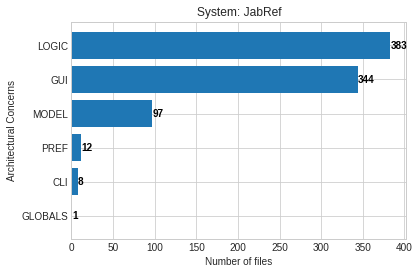

In [10]:
dataset_df = pd.read_csv(raw_data_csv)
y_labels = dataset_df.Label.unique()
x_quantity = [len(dataset_df.loc[dataset_df['Label']==label]) for label in y_labels]
tmp_df = pd.DataFrame({
    'Labels' : y_labels,
    'Quantity' : x_quantity
})
tmp_df = tmp_df.sort_values(by=['Quantity'])
plt.style.use("seaborn-whitegrid")
plt.barh(y=tmp_df.Labels, width=tmp_df.Quantity)
for i, v in enumerate(tmp_df.Quantity):
    plt.text(v, i, str(v), color='black', fontweight='bold', ha='left', va='center')

plt.xlabel('Number of files')
plt.ylabel('Architectural Concerns')
plt.title('System: JabRef')

The figure above shows the number of files each label has.

----

# Evaluation

### Static parts
__Train-test split,__ will be set at 10% for training, and 90% for evaluation.  
* __Metrics,__ the most relevant ones will be the following:  
   * Confusion matrix  
   * Precission  
   * Accuracy  
   * F1-score/value  
   * Average score 
    
----

# TEST

In [ ]:
setting = preprocess_settings['s0']
Prep.preprocess_settings(setting, raw_data_csv, processed_data_csv)

Seen above we choose a pre-process setting then use that setting to extract and parse data from the files.
All the available settings are found in the config.yaml file.

In [ ]:
test_df = pd.read_csv(processed_data_csv)
# Remove GLOBALS and CLI from the dataset
df_sliced = Utils.remove_concerns_under_quantity_threshold(test_df)
test_size=0.9
fold_quantity = 100
feature_representation = CountVectorizer()
confusion_list = []

# Train and gather evaluation metrics
evaluate = Eva.Evaluation(df_sliced, feature_representation, test_size, fold_quantity, 10)
classifier_max_ent , metrics_max_ent = evaluate.evaluate_MaxEnt()
classifier_svm , metrics_svm = evaluate.evaluate_SVM()
classifier_naive, metrics_naive = evaluate.evaluate_Naive_Bayes()

metrics = {
    'maxEnt': metrics_max_ent,
    'SVM': metrics_svm,
    'Naive': metrics_naive
}

In [ ]:
Graphs.plot_horizontal_graphs(metrics, 'norm')

# Confusion matrix
    - Each row represents a concern
    - the diagonal indicates the number of true positives that successfully mapped to the right concern
    
    

In [ ]:
Graphs.plot_horizontal_graphs(metrics, 'regular')

 # Classification report
     - Shows each concern precision, recall and F1-score
     - Shows the classifiers overall accuracy, that is the # TP divided by all files
     - We mainly base results on macro avg, takes the small classes into consideration

In [ ]:
Graphs.plot_horizontal_graphs(metrics, 'report')

## Prediction probability bar-graph
Each bar-graph shows the average probability of which architectural concern   
the classifier will predict when the classifier is given files.  
The files then belong to the architectural concern that is specified on top of the bar-graph.  
  

In [ ]:
Graphs.plot_predictionScoreAverage(metrics_max_ent, classifier_max_ent)
Graphs.plot_predictionScoreAverage(metrics_svm, classifier_svm)
Graphs.plot_predictionScoreAverage(metrics_naive, classifier_naive)

In [ ]:
df = metrics_svm.total_report_table()
df